## Goal and objectives

The overall goal is to predict units sold from prices (and potentially other features).

The main objectives:

1. Compare blackbox-ML and discrete choice approaches

2. Meaningful feature engineering / inclusion (we don't expect anything crazy here). *Think about what makes you choose between different products in a supermarket given their prices*.
3. Evaluation of Models. But with the right perspective. How can you evaluate which of given two models performs better for a given use case? *Imagine that your client is a producer in the category you have chosen
and uses your models to evaluate different scenarios, on the basis of which he will negotiate prices with Dominick's.*

## Data selection

We decided to use the Cigarettes dataset. All zeros in the PRICE column will be removed, and also the data will be slised to contain only records for one of the stores with the highest profits. 

## Import libraries

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

## Load data

Two datasets are loaded:

1. wtna.csv - contains sales information at the store level for each upc in the category. The information is stored on a weekly basis.

2. upctna.csv - contains a description of each UPC in the category.

In [6]:
df_full = pd.read_csv('data/wcig.csv')
df_full.head()

/var/folders/k_/pt0pmhm97jx4hphkj9n4303w0000gn/T/ipykernel_666/1907445893.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_full = pd.read_csv('data/wcig.csv')


,STORE,UPC,WEEK,MOVE,QTY,PRICE,SALE,PROFIT,OK,PRICE_HEX,PROFIT_HEX
0,8,190,194,0,1,0.00,NaN,0.00,1,0000000000000000,0000000000000000
1,8,190,195,2,1,21.51,NaN,50.49,1,4035828F5C28F5C3,40493EB851EB851F
2,8,190,196,0,1,0.00,NaN,0.00,1,0000000000000000,0000000000000000
3,8,190,197,0,1,0.00,NaN,0.00,1,0000000000000000,0000000000000000
4,8,190,198,0,1,0.00,NaN,0.00,1,0000000000000000,0000000000000000


In [7]:
df_full.shape

(5398197, 11)

In [8]:
# Find top 5 stores by profit
df_full.groupby("STORE")["PROFIT"].sum().sort_values(ascending=False)[:5].index

Int64Index([80, 112, 122, 131, 84], dtype='int64', name='STORE')

As the wtna.csv file has too many records to process on our local machines, we decided to create a subsample of the data.

From now on, our focus is on the data for all products from one store only. The selected store is the most profitable among all in the dataset.

We decided to choose store 112 as there were also some promotions.

In [9]:
# Select store with the highest profit & promotions available - 112
df_full = df_full[df_full.STORE == 112]

# Filter out price == 0
df_full = df_full[df_full.PRICE != 0.00]

# Save subsample of the data so whenewer we want to load our data, we don't have to load the full dataset again
df_full.to_csv('data/wcig_slised.csv')

In [10]:
# Load movement data
df_movement = pd.read_csv('data/wcig_slised.csv', index_col=0)
df_movement.head()

,STORE,UPC,WEEK,MOVE,QTY,PRICE,SALE,PROFIT,OK,PRICE_HEX,PROFIT_HEX
1151,112,190,191,1,1,5.99,S,-77.79,1,4017F5C28F5C28F6,C053728F5C28F5C3
1161,112,190,201,2,1,5.99,S,-77.79,1,4017F5C28F5C28F6,C053728F5C28F5C3
18795,112,193,1,8,1,2.01,NaN,33.78,1,4000147AE147AE14,4040E3D70A3D70A4
18796,112,193,2,2,1,2.05,NaN,35.07,1,4000666666666666,404188F5C28F5C29
18797,112,193,3,2,1,2.01,NaN,33.78,1,4000147AE147AE14,4040E3D70A3D70A4


In [11]:
# Load UPC data

df_upc = pd.read_csv('data/upccig.csv', encoding='latin-1')
df_upc.head()

,COM_CODE,UPC,DESCRIP,SIZE,CASE,NITEM
0,700,190,KING CARTON CIGS (PL,1 CT,1,86040
1,700,191,100'S CARTON CIGS (P,1 CT,1,86060
2,705,193,25 CT SINGLE PACK CI,1 CT,8,80080
3,705,194,GENERIC SINGLE,1 CT,10,80020
4,700,195,KING CARTON PRICE VA,1 CT,1,86050


In [12]:
# Add data from df_upc to df_movement

df = pd.merge(df_movement, df_upc, on='UPC', how='left')

In [13]:
df.head()

,STORE,UPC,WEEK,MOVE,QTY,PRICE,SALE,PROFIT,OK,PRICE_HEX,PROFIT_HEX,COM_CODE,DESCRIP,SIZE,CASE,NITEM
0,112,190,191,1,1,5.99,S,-77.79,1,4017F5C28F5C28F6,C053728F5C28F5C3,700,KING CARTON CIGS (PL,1 CT,1,86040
1,112,190,201,2,1,5.99,S,-77.79,1,4017F5C28F5C28F6,C053728F5C28F5C3,700,KING CARTON CIGS (PL,1 CT,1,86040
2,112,193,1,8,1,2.01,NaN,33.78,1,4000147AE147AE14,4040E3D70A3D70A4,705,25 CT SINGLE PACK CI,1 CT,8,80080
3,112,193,2,2,1,2.05,NaN,35.07,1,4000666666666666,404188F5C28F5C29,705,25 CT SINGLE PACK CI,1 CT,8,80080
4,112,193,3,2,1,2.01,NaN,33.78,1,4000147AE147AE14,4040E3D70A3D70A4,705,25 CT SINGLE PACK CI,1 CT,8,80080


In [14]:
# Drop unnecessary columns

df.drop(columns=['OK', 'PRICE_HEX', 'PROFIT_HEX', 'COM_CODE'], inplace=True)

## Exploratory Data Analysis

In [15]:
df.shape

(36648, 12)

In [16]:
# Display basic information about the dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36648 entries, 0 to 36647
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   STORE    36648 non-null  int64  
 1   UPC      36648 non-null  int64  
 2   WEEK     36648 non-null  int64  
 3   MOVE     36648 non-null  int64  
 4   QTY      36648 non-null  int64  
 5   PRICE    36648 non-null  float64
 6   SALE     2 non-null      object 
 7   PROFIT   36648 non-null  float64
 8   DESCRIP  36648 non-null  object 
 9   SIZE     36648 non-null  object 
 10  CASE     36648 non-null  int64  
 11  NITEM    36648 non-null  int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 3.6+ MB


In [17]:
# Summary statistics for numerical columns

df.describe()

,STORE,UPC,WEEK,MOVE,QTY,PRICE,PROFIT,CASE,NITEM
count,36648.0,3.664800e+04,36648.000000,36648.000000,36648.0,36648.000000,36648.000000,36648.000000,36648.000000
mean,112.0,1.761521e+09,218.557302,10.268118,1.0,8.621210,43.723138,4.722550,85796.839937
std,0.0,7.692921e+08,110.138630,105.110184,0.0,7.983135,14.700721,4.416116,1395.953401
min,112.0,1.900000e+02,1.000000,1.000000,1.0,0.890000,-98.660000,1.000000,80010.000000
25%,112.0,1.230000e+09,128.000000,1.000000,1.0,2.540000,35.770000,1.000000,86030.000000
50%,112.0,1.230015e+09,222.000000,3.000000,1.0,2.790000,40.800000,1.000000,86120.000000
75%,112.0,2.610000e+09,316.000000,6.000000,1.0,17.650000,50.200000,10.000000,86130.000000
max,112.0,8.030071e+09,399.000000,2648.000000,1.0,25.000000,96.200000,10.000000,88600.000000


In [18]:
#  Check for missing values

print(df.isnull().sum())

STORE          0
UPC            0
WEEK           0
MOVE           0
QTY            0
PRICE          0
SALE       36646
PROFIT         0
DESCRIP        0
SIZE           0
CASE           0
NITEM          0
dtype: int64


For column SALE, missing values are the products that were sold without a promotion.

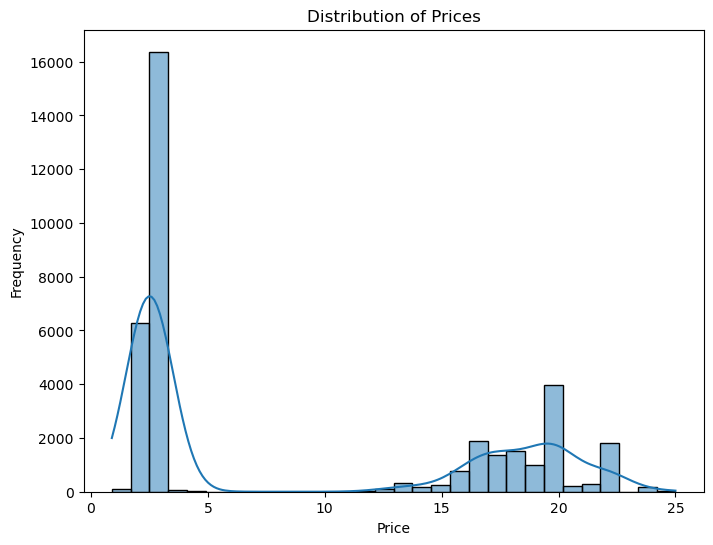

In [19]:
# Visualize the distribution of the variable 'PRICE'

plt.figure(figsize=(8, 6))
sns.histplot(df['PRICE'], bins=30, kde=True)
plt.title('Distribution of Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [20]:
# Check values in the SIZE column

df.SIZE.unique()

array(['1 CT', '10 PK', '10 CT', '5 CT'], dtype=object)

In [21]:
# Check values in the CASE column

df.CASE.unique()

array([ 1,  8, 10])

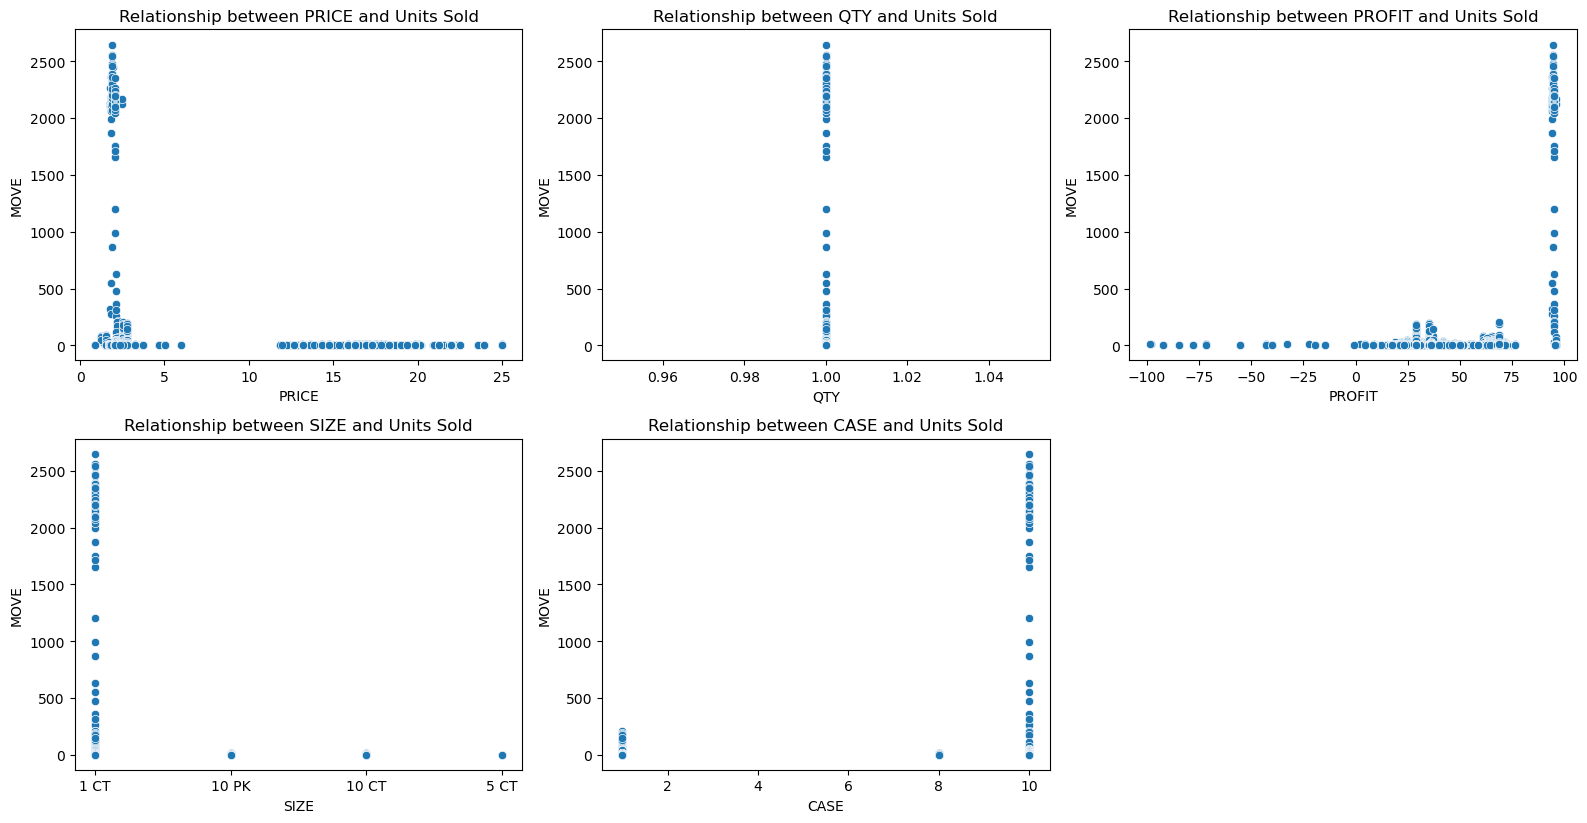

In [22]:
# Visualize the relationships between features and the target 'MOVE'

numerical_features = ['PRICE', 'QTY', 'PROFIT', 'SIZE', 'CASE']

plt.figure(figsize=(16, 12))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 3, i)
    sns.scatterplot(data=df, x=feature, y='MOVE')
    plt.title(f'Relationship between {feature} and Units Sold')

plt.tight_layout()
plt.show()

In [23]:
df.groupby("SALE")["MOVE"].mean()

SALE
S    1.5
Name: MOVE, dtype: float64

In [24]:
# Crete dummy variables from the categorical column SALE

df = pd.get_dummies(df, columns=['SALE', 'SIZE'], dummy_na=False)

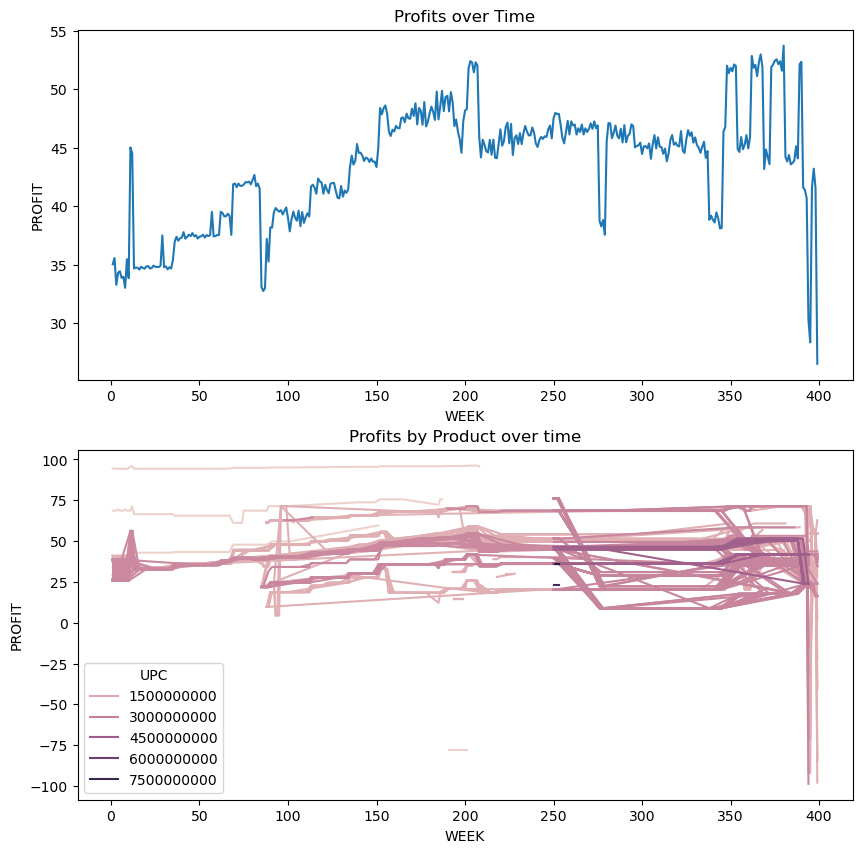

In [25]:
fig, ax = plt.subplots(2,1, figsize=(10,10))
sns.lineplot(df, x="WEEK", y="PROFIT", errorbar=None, ax=ax[0])
ax[0].set_title("Profits over Time")
sns.lineplot(df, x="WEEK", y="PROFIT", hue="UPC",errorbar=None, ax=ax[1])
ax[1].set_title("Profits by Product over time")
plt.show()

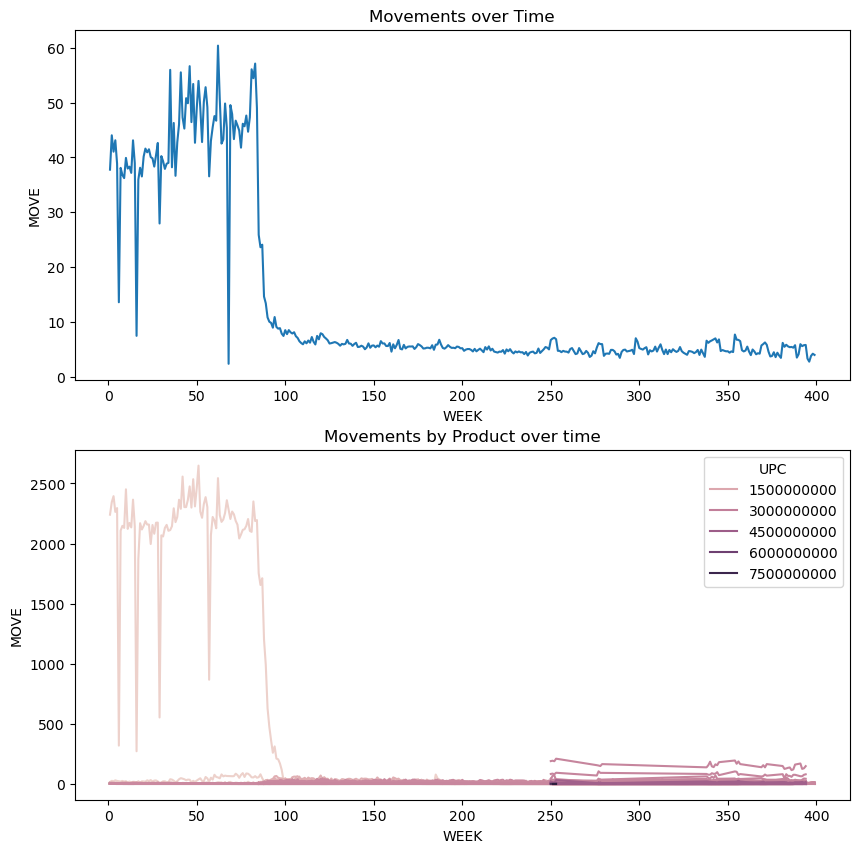

In [26]:
fig, ax = plt.subplots(2,1, figsize=(10,10))
sns.lineplot(df, x="WEEK", y="MOVE", errorbar=None, ax=ax[0])
ax[0].set_title("Movements over Time")
sns.lineplot(df, x="WEEK", y="MOVE", hue="UPC",errorbar=None, ax=ax[1])
ax[1].set_title("Movements by Product over time")
plt.show()

### Feature Selection and Modelling

### Discrete Choice - multinomial logit

We tried to use MNLogit from statsmodels. The perfprmance of it is very slow and we were not able to run the model summary. Also, we are not sure why this model is suggested to be used here, as it's a classification model for predicting categorical data, while in our case we want to predict the number of units sold wich is numerical data.

In [ ]:
# Convert the 'move' column into categorical format
df['MOVE'] = df['MOVE'].astype('category')

# Define features and target variable
X = df[['QTY', 'PRICE', 'PROFIT', 'CASE', 'SALE_S']]
y = df['MOVE']

# Fit the multinomial logit model
mlogit_model = sm.MNLogit(y, sm.add_constant(X))  # Add a constant term
mlogit_result = mlogit_model.fit(method='lbfgs', maxiter=100)

In [ ]:
print(mlogit_result.summary())

We also tried to use sklearn LogisticRegression implementation of a multinomial logit model, but the model does not perform well for this problem.

In [27]:
# Define features and target variable
X = df[['UPC','QTY', 'PRICE', 'PROFIT', 'CASE', 'SALE_S']]
y = df['MOVE']

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the logistic regression model
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs')
log_reg.fit(X_train, y_train)

# Predict the target variable
y_pred = log_reg.predict(X_test)

# Evaluate the model
accuracy = log_reg.score(X_test, y_test)
print(f'Accuracy: {accuracy:.2f}')

# Calculate the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Accuracy: 0.31
Mean Squared Error: 12811.88335607094


/Users/viktoriia/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Black Box ML Models

In [28]:
# Define features and target variable
X = df[['UPC','QTY', 'PRICE', 'PROFIT', 'CASE', 'SALE_S']]
y = df['MOVE']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:


# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor()

# Fit the model to the training data
rf_regressor.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_regressor.predict(X_test)

# Calculate the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Evaluate the model
rf_score = rf_regressor.score(X_test, y_test)
print(rf_score)

Mean Squared Error: 214.75376413930118
0.9831029312738858


In [30]:
# Fit the GradientBoostingRegressor model
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = gb_model.predict(X_test)

# Calculate the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Evaluate the model
gb_score = gb_model.score(X_test, y_test)
print(gb_score)

Mean Squared Error: 194.02595613144433
0.9847338186199315


In this case, blackbox models performance show good results. For both models result are quite close. 